In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('creditcard.csv')
print('Information about DataFrame')
df.info()
display(df.describe().T)

FileNotFoundError: [Errno 2] No such file or directory: 'creditcard.csv'

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.isnull().sum().all()

np.False_

### * We will pay particular attention to the ‘Amount’ column.
### * Other columns (V1, V2... V28) have already been transformed (PCA applied) by the bank for privacy reasons.

In [ ]:
class_counts = df['Class'].value_counts()
print('Distribution of Class:\n', class_counts)

Distribution of Class:
 Class
0    284315
1       492
Name: count, dtype: int64


#### * 0: Normal, 1: Fraud


In [ ]:
print('Distribution Rate of Class:\n',df['Class'].value_counts(normalize=True)*100)

Distribution Rate of Class:
 Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


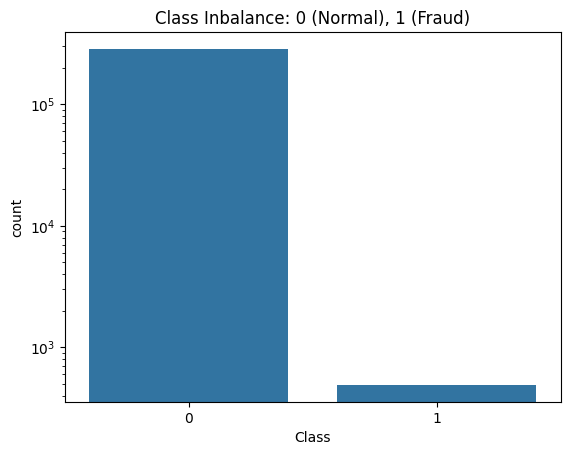

In [ ]:
sns.countplot(x='Class', data=df)
plt.title('Class Inbalance: 0 (Normal), 1 (Fraud)')
plt.yscale('log')
plt.show()

- The V1, V2... V28 columns in our dataset have already been converted by the bank and pulled into similar ranges (approximately between -5 and +5). However, when we look at the Amount column, we see huge numbers ranging from 0 dolar to 25000 dolars.

- Machine Learning models (especially Logistic Regression and Neural Networks) perceive large numbers as “more important.” A 25000 dolars transaction should not be mathematically weighted 25,000 times more than a  1 dolar transaction. Therefore, we will compress this column.

- We transform each value using the formula z = (x - u) / s so that the mean is 0 and the standard deviation is 1.

In [ ]:
scaler = StandardScaler()
# Select the ‘Amount’ column and reshape it into a 2D array using reshape(-1, 1) (fit_transform requires this).
# Then we transform it and assign it to a new column named ‘scaled_amount’.
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [ ]:
# The ‘Time’ column also contains very large second values, so let's scale that too.
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [ ]:
# We are now removing the original ‘Time’ and ‘Amount’ columns that are no longer useful to us.
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

In [ ]:
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_insert', scaled_time)

In [ ]:
print('Standardization Complete!\n')
df.head()

Standardization Complete!



,scaled_amount,scaled_insert,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train Size:", X_train.shape)
print("Test Size:", X_test.shape)

Train Size: (227845, 30)
Test Size: (56962, 30)


- Since the data is very unbalanced, there is a risk that no fraudsters will be included in the test set when dividing randomly.
- The ‘stratify=y’ command means “Maintain the 0.17% ratio in the original data in both the train and test sets.”

In [ ]:
model_baseline = LogisticRegression()
model_baseline.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model_baseline.predict(X_test)

In [ ]:
print('*********** Baseline Model Results ***********')
print('Accuracy Score:\n', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n',confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

*********** Baseline Model Results ***********
Accuracy Score:
 0.9991573329588147

Confusion Matrix:
 [[56851    13]
 [   35    63]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
print('Distribution of Train Set Before SMOTE')
print(y_train.value_counts())

Distribution of Train Set Before SMOTE
Class
0    227451
1       394
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=42)
# We only perform fit_resample (learn and resample) on X_train and y_train.
# This process replicates the minority class (1) until it equals the number of the majority class (0).
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
print('Distribution of Train Set After SMOTE')
print(y_train_smote.value_counts())

Distribution of Train Set After SMOTE
Class
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
model_smote = LogisticRegression()
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test)

In [ ]:
print("********** Model Results After SMOTE **********")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_smote):.4f}")

cm = confusion_matrix(y_test, y_pred_smote)
print("\nConfusion Matrix (SMOTE):\n", cm)

********** Model Results After SMOTE **********
Accuracy Score: 0.9743

Confusion Matrix (SMOTE):
 [[55406  1458]
 [    8    90]]


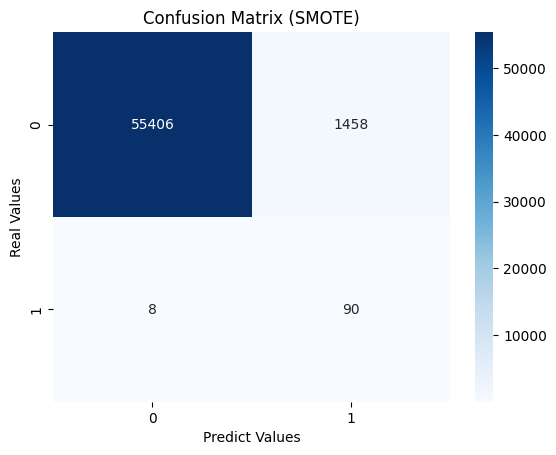

In [ ]:
cm = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (SMOTE)")
plt.ylabel('Real Values')
plt.xlabel('Predict Values')
plt.show()

In [ ]:
print("Classification Results (SMOTE):")
print(classification_report(y_test, y_pred_smote))

Classification Results (SMOTE):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



#### Which is better for the bank? Missing a $1 million fraud (Low Recall), or sending SMS messages to a few customers asking “Did you make this transaction?” and annoying them (Low Precision)? Banks generally prefer High Recall. So SMOTE worked!

In [ ]:
# We take the model's ‘probability’ predictions (only the probability of being class ‘1’).
# predict_proba() returns [Normal_Probability, Fraud_Probability], we take the second one with [:, 1].
y_pred_proba = model_smote.predict_proba(X_test)[:, 1]

In [ ]:
# We calculate the FPR (False Positive Rate) and TPR (True Positive Rate) values.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [ ]:
# Calculate AUC Score 
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9698


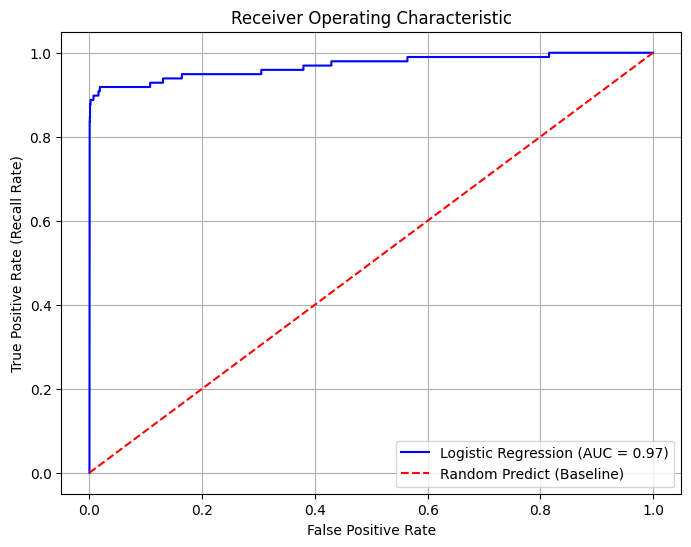

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Predict (Baseline)') # Köşegen çizgi (Rastgele)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### You will see how close the blue line is to the upper left corner. The closer the line is to the upper left, the better the model is (meaning it can catch scammers without giving false alarms).